In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster

# 3.0 KL Divergence
The general idea of Variational inference is to approximate an intractable distribution with a simpler one. To achieve this, some metric is used to measure the difference between the two distributions, and some procedure to minimize this difference is applied.

The most common metric used is the Kullback-Leibler divergence (KL-divergence) and is defined as:
$$ KL(q||p) = \int q(x) \log \frac{q(x)}{p(x)} dx $$  
  
Here, we examine the KL-divergence between different distributions and see that it makes sense with our intuition of which distributions should be similar compared to the Euclidean norm.

## 3.0.1 KL-divergence and Euclidean norm functions and tests

In [39]:
import scipy.integrate as sp_int


def KL_divergence(p_1, p_2, a=-np.inf, b=np.inf):
    D_KL, err = sp_int.quad(lambda x: p_1(x) * np.log(p_1(x)/p_2(x)), a, b)
    return D_KL

def Euclidean_norm(p_1, p_2, a, b):
    D_Euc, err = np.sqrt(sp_int.quad(lambda x: (p_1(x) - p_2(x))**2, a, b))
    return D_Euc


# Test our functions - e.g. when the two distributions are the same, the distances should be 0
mu_1_test = 0
mu_2_test = 0
sigma_1_test = 1
sigma_2_test = 1

p_1_test = lambda x: 1/(np.sqrt(2*np.pi) * sigma_1_test) * np.exp(-(x-mu_1_test)**2/(2 * sigma_1_test))
p_2_test = lambda x: 1/(np.sqrt(2*np.pi) * sigma_2_test) * np.exp(-(x-mu_2_test)**2/(2 * sigma_2_test))

D_KL = KL_divergence(p_1_test, p_2_test, -5, 5)  # Evaluate on [-5, 5] instead of [-inf, inf] for stability reasons
D_Euclidean = Euclidean_norm(p_1_test, p_2_test, -5, 5)

print(f"KL-divergence: {D_KL}")
print(f"Euclidean norm: {D_Euclidean}")

KL-divergence: 0.0
Euclidean norm: 0.0


## 3.0.2 Plot the two distributions and compare KL-divergence and Euclidean norm

Given two Gamma distributions, we plot them and compare the KL-divergence and Euclidean norm between them.

In [40]:
import scipy.special as sp_spec

def pdf_gamma(alpha, beta):
    # Pdfs for Gamma distributions (check Wikipedia)
    return lambda x: beta**alpha / (sp_spec.gamma(alpha)) * x**(alpha - 1) * np.exp(-beta * x)

def plot_two_pdfs(p_1, p_2, a, b):
    x = np.linspace(a, b, 100)
    y1 = p_1(x)
    y2 = p_2(x)

    plt.plot(x, y1, label=r'$p_1(x)$')
    plt.plot(x, y2, label=r'$p_2(x)$')
    plt.legend(loc='best')

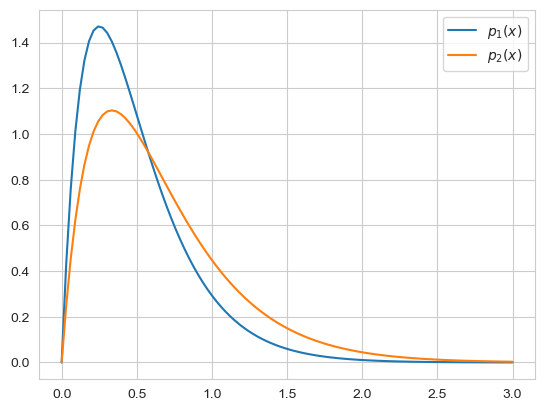

KL-divergence: 0.07557931685525016
Euclidean norm: 0.26589083841633293


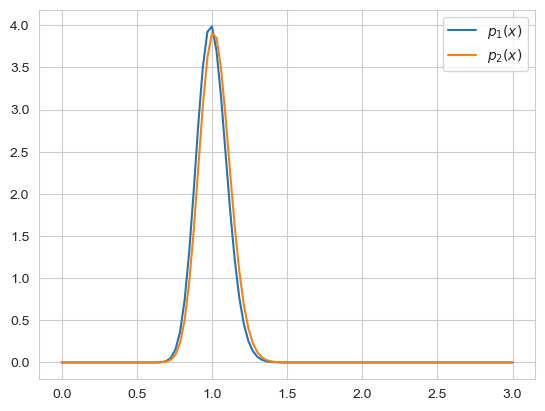

KL-divergence: 0.020270731751944743
Euclidean norm: 0.23857017214893247


In [41]:
# Case 1
alpha_1 = 2
beta_1 = 4
alpha_2 = 2
beta_2 = 3


p_1 = pdf_gamma(alpha_1, beta_1)
p_2 = pdf_gamma(alpha_2, beta_2)

interval_a = 0
interval_b = 3
plot_two_pdfs(p_1, p_2, interval_a, interval_b)
plt.show()

D_KL_case1 = KL_divergence(p_1, p_2, interval_a, interval_b)
D_Euclidean_case1 = Euclidean_norm(p_1, p_2, interval_a, interval_b)

print(f"KL-divergence: {D_KL_case1}")
print(f"Euclidean norm: {D_Euclidean_case1}")

# Case 2
alpha_1 = 100
beta_1 = 100
alpha_2 = 100
beta_2 = 98

p_1 = pdf_gamma(alpha_1, beta_1)
p_2 = pdf_gamma(alpha_2, beta_2)

plot_two_pdfs(p_1, p_2, interval_a, interval_b)
plt.show()

D_KL_case2 = KL_divergence(p_1, p_2, interval_a, interval_b)
D_Euclidean_case2 = Euclidean_norm(p_1, p_2, interval_a, interval_b)

print(f"KL-divergence: {D_KL_case2}")
print(f"Euclidean norm: {D_Euclidean_case2}")


In [42]:
relative_KL = D_KL_case1/D_KL_case2
relative_Euclidean = D_Euclidean_case1/D_Euclidean_case2

print(f"Relative KL-divergence: {relative_KL}")
print(f"Relative Euclidean norm: {relative_Euclidean}")

Relative KL-divergence: 3.728494747013718
Relative Euclidean norm: 1.1145183659017732


## 3.0.3 Discussion

Looking at the plots, we see that the distributions in case 1 are more different than the distributions in case 2. We want a metric that captures this intuition.

The Euclidean norm suggests that the differences between the distributions in the two cases are similar, which is not in line with our intuition.

The KL-divergence suggest an almost 4 times larger difference between the distributions in case 1 compared to case 2, which better captures our intuition.

# 3.1 Gaussian Mixture Model (GMM)

This workshops revolves around implementing the CAVI algorithm for a Gaussian Mixture Model (GMM), similar to the model which was introduced in the video lectures of Module 3, but with the simplification that $\mu_k$ is Normal distributed and $\tau_k$ is Gamma distributed, instead of $\mu_k, \tau_k$ being jointly Normal-Gamma distributed.



### 3.1.1.2 Priors

The priors for the GMM model are.

Component means prior:
$$ p(\mu_k) = \mathcal{N}(\mu_k | \nu_0, \lambda_0) $$
Component precisions prior:
$$ p(\tau_k) = \text{Gamma}(\tau_k | \alpha_0, \beta_0) $$

Class variable prior:
$$ p(Z | \pi) = \prod_{n=1}^N \text{Categorical}(\pi) $$

Mixture weights prior:
$$ p(\pi) = \text{Dir}(\pi | \delta_0) $$


## 3.1.1 Model description and Bayesian Network

Always start by defining the model and the Bayesian Network to get an overview of the problem.

### 3.1.1.1 Observation model
The likelihood for the GMM model is defined as:
$$ p(X_n=x_n | \mu, \tau) = \sum_{k=1}^K \pi_k \mathcal{N}(x_n | \mu_k, \tau_k) \qquad (1)$$

Instead, we will work with the model on latent variable form as (as described in Bishop 9.2):
$$ p(X_n=x_n | Z_n, \mu, \tau) = \prod_{k=1}^K \mathcal{N}(x_n | \mu_k, \tau_k)^{I(Z_n = k)} \qquad (2)$$

which is an easier form to work with. $(1)$ and $(2)$ are equivalent when $(2)$ is marginalized over $Z_n$, i.e., 
$p(X_n=x_n | \mu, \tau) = \sum_k p(X_n=x_n | Z_n=k, \mu_k, \tau_k)p(Z_n=k | \pi)$.

### 3.1.1.2 Bayesian Network

Write out the Bayesian Network for the model described above.

Draw on board.

## 3.1.2 Generate data
Next we generate some data to work with. This is also a good way to get a better understanding of the model and the problem.



In [43]:
def generate_data(N, K, nu_0, lambda_0, alpha_0, beta_0, delta_0):
    # Generate the component concentrations parameters pi
    pi_true = generate_pi(delta_0)
    mu_true = generate_mu(nu_0, lambda_0, K)
    tau_true = generate_tau(alpha_0, beta_0, K)
    
    # Generate the latent variables
    Z_true = generate_Z(N, pi_true)
    
    # Generate the data
    X = generate_X(N, mu_true, tau_true, Z_true)
    
    return X, Z_true, pi_true, mu_true, tau_true

def generate_pi(delta_0):
    return np.random.dirichlet(delta_0)

def generate_mu(nu_0, lambda_0, K):
    mu = np.zeros(K)
    for k in range(K):
        mu[k] = np.random.normal(nu_0, 1/np.sqrt(lambda_0))
    return mu

def generate_tau(a_0, b_0, K):
    return np.random.gamma(a_0, 1/b_0, K)

def generate_Z(N, pi_true):
    return np.random.multinomial(1, pi_true, size=N).argmax(axis=1)

def generate_X(N, mu_true, tau_true, Z):
    X = np.zeros(N)
    for n in range(N):
        k = Z[n]
        X[n] = np.random.normal(mu_true[k], 1/np.sqrt(tau_true[k]))
    return X
    

### Test the data generation functions

In [44]:
K_test = 2
N_test = 1000

# Fix mu_1 and mu_2 and tau_1 and tau_2
mu_1_test = 5
mu_2_test = 1
mu_test = [mu_1_test, mu_2_test]
tau_test = [1, 1]

# Fix pi - biased towards component 1
pi_test = np.array([0.8, 0.2])

Z_test = generate_Z(N_test, pi_test)
X_test = generate_X(N_test, mu_test, tau_test, Z_test)

print(f"X mean: {X_test.mean()}")
#assert X_test.mean() > 60.0  # Expect the mean of X to be much closer to mu_1 than mu_2
Z_test_one_hot = np.eye(K_test)[Z_test]
print(f"Z: {Z_test_one_hot.mean(axis=0)}")
#assert np.allclose(Z_test_one_hot.mean(axis=0), pi_test, atol=0.1)  # Expect the mean of Z to be close to pi

X mean: 4.2017544295229925
Z: [0.796 0.204]


(array([  2.,   1.,   7.,   6.,   9.,  13.,  23.,  25.,  31.,  34.,  15.,
         16.,  12.,  15.,  19.,  25.,  41.,  56.,  71.,  88., 100.,  96.,
        111.,  63.,  48.,  29.,  27.,  11.,   5.,   1.]),
 array([-1.61459686, -1.29705641, -0.97951597, -0.66197553, -0.34443509,
        -0.02689465,  0.29064579,  0.60818624,  0.92572668,  1.24326712,
         1.56080756,  1.878348  ,  2.19588844,  2.51342889,  2.83096933,
         3.14850977,  3.46605021,  3.78359065,  4.10113109,  4.41867154,
         4.73621198,  5.05375242,  5.37129286,  5.6888333 ,  6.00637374,
         6.32391419,  6.64145463,  6.95899507,  7.27653551,  7.59407595,
         7.9116164 ]),
 <BarContainer object of 30 artists>)

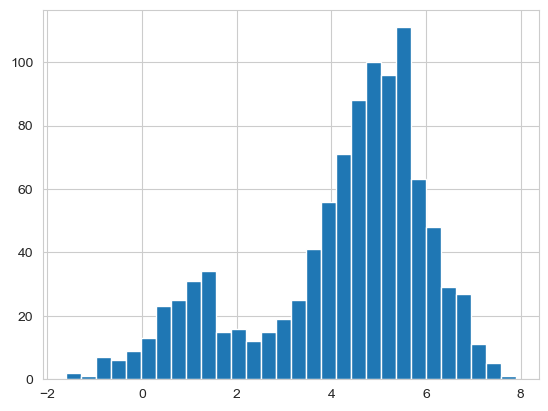

In [45]:
plt.hist(X_test, bins=30)

## 3.1.3 Coordinate ascent VI (CAVI)

General algorithm for CAVI for the GMM:
1. Initialize the variational parameters $\gamma$.
2. While the ELBO has not converged:
    3. Update the variational parameters for each latent variable $z_n$.
    4. Update the variational parameters for each component mean $\mu_k$.
    5. Update the variational parameters for each component precision $\tau_k$.
    6. Update the variational parameters for the class variable $\pi$.
    7. Calculate the ELBO. (To measure convergence).


### CAVI updates

Derivation on board, and taken from the video lectures.

When deriving the CAVI updates, always begin with writing out the factorization of the joint:

$$ p(X, Z, \mu, \tau, \pi) = p(X | Z, \mu, \tau) p(Z | \pi) p(\mu) p(\tau) p(\pi) $$

And the minimum mean-field approximation:
$$ q(Z, \mu, \tau, \pi) = q(Z)q(\pi, \mu, \tau)$$

Which, in video lectures, are shown to simplify further to: 
$$q(Z)q(\pi, \mu, \tau) = q(Z) q(\pi) \prod_k q(\mu_k) q(\tau_k) $$

Then apply the CAVI update equations for each variational distribution. Let's start with $q(\mu_k)$:

$$ \log q^*(\mu_k) \stackrel{+}{=} \mathbb{E}_{q(Z, \mu_{\neg k}, \tau, \pi)}\big[\log p(X, Z, \mu, \tau, \pi)\big] $$

Derive on board.

### Fixed updates

## 3.1.4 Running the CAVI algorithm on simulated data

In [46]:
def CAVI_update_mu_k(x, q_Z_k, E_tau_k, nu_0, lambda_0):
    """
    Implement this based on the CAVI update derived on the board.
    """
    sum_qZ = np.einsum('n->', q_Z_k)
    sum_qZ_x = np.einsum('n,n->', q_Z_k, x)
    lambda_star = sum_qZ * E_tau_k + lambda_0
    nu_star = (1 / lambda_star) * (sum_qZ_x * E_tau_k + lambda_0 * nu_0)
    return nu_star, lambda_star


# Updates based on the video lectures (slight modifications)
def CAVI_update_Z(E_log_tau, E_tau, E_x_mu2, E_log_pi):
    N, K = E_x_mu2.shape
    E_log_tau = np.einsum('n,k->nk', np.ones(N), E_log_tau)
    E_tau = np.einsum('n,k->nk', np.ones(N), E_tau)
    E_log_pi = np.einsum('n,k->nk', np.ones(N), E_log_pi)
    log_rho = 1/2 * E_log_tau - 1/2 * np.log(2*np.pi) - 1/2 * E_tau * E_x_mu2 + E_log_pi
    log_rho_norm = log_rho - sp_spec.logsumexp(log_rho, axis=1, keepdims=True)
    rho_star = np.exp(log_rho_norm)
    return rho_star


def CAVI_update_tau(q_Z, alpha_0, beta_0, E_x_mu2):
    alpha_star = 1/2 * np.einsum('nk->k', q_Z) + alpha_0
    beta_star = 1/2 * np.einsum('nk,nk->k', q_Z, E_x_mu2) + beta_0
    return alpha_star, beta_star


def CAVI_update_pi(q_Z, delta_0):
    delta_star = q_Z.sum(axis=0) + delta_0
    return delta_star


def calculate_ELBO(x, r_q, nu_q, lambda_q, alpha_q, beta_q, delta_q, prior_params):
    nu_0, lambda_0, alpha_0, beta_0, delta = prior_params
    N, K = x.shape[0], nu_q.shape[0]

    E_tau = alpha_q / beta_q
    E_log_tau = sp_spec.digamma(alpha_q) - np.log(beta_q)
    E_log_pi = sp_spec.digamma(delta_q) - sp_spec.digamma(np.sum(delta_q))
    E_mu = nu_q
    E_mu2 = nu_q ** 2 + 1 / lambda_q ** 2

    x_n2_rnk_sum_n = np.einsum('n, nk->k', x ** 2, r_q)
    x_n_rnk_sum_n = np.einsum('n, nk->k', x, r_q)
    rnk_sum_n = np.einsum('nk->k', r_q)

    ELBO_p_X_Z_mu_tau = 1/2 * np.einsum('k, k->', E_log_tau, np.sum(r_q, axis=0)) - N/2 * np.log(2 * np.pi) - \
                1/2 * np.einsum('k, k->', E_tau, x_n2_rnk_sum_n - 2 * x_n_rnk_sum_n * E_mu + E_mu2 * rnk_sum_n)

    ELBO_p_Z_pi = np.einsum('nk,k->', r_q, E_log_pi)
    ELBO_p_mu = np.einsum('k->', 1/2 * np.log(lambda_0) - 1/2 * np.log(2*np.pi)
                          - 1/2 * lambda_0 * (E_mu2 - 2*E_mu*nu_0 + nu_0**2))
    ELBO_p_tau = np.einsum('k->', alpha_0*np.log(beta_0) - sp_spec.gammaln(alpha_0)
                            + (alpha_0 - 1)*E_log_tau - beta_0*E_tau)
    log_Beta_func_delta_0 = sp_spec.gammaln(delta).sum() - sp_spec.gammaln(np.sum(delta))
    ELBO_p_pi = np.einsum('k->', (delta - 1) * E_log_pi) - log_Beta_func_delta_0

    H_qZ = -np.einsum('nk->', r_q * np.log(r_q))
    H_qmu = 1/2 * np.einsum('k->', -np.log(lambda_q) + 1 + np.log(2*np.pi))
    H_qtau = np.einsum('k->', sp_spec.gammaln(alpha_q) - (alpha_q - 1)*sp_spec.psi(alpha_q) - np.log(beta_q)
                        + alpha_q)
    log_Beta_func_delta_q = sp_spec.gammaln(delta_q).sum() - sp_spec.gammaln(np.sum(delta_q))
    delta_q_sum = np.sum(delta_q)
    H_qpi = log_Beta_func_delta_q + (delta_q_sum - K)*sp_spec.digamma(delta_q_sum) - ((delta_q - 1)*sp_spec.digamma(delta_q)).sum()

    ELBO = ELBO_p_X_Z_mu_tau + ELBO_p_Z_pi + ELBO_p_mu + ELBO_p_tau + ELBO_p_pi + H_qZ + H_qmu + H_qtau + H_qpi
    return ELBO


def CAVI_algorithm(x, K, prior_params, max_iter=100, tol=1e-3, step_size=0.01):
    N = x.shape[0]
    nu_0, lambda_0, alpha_0, beta_0, delta_0 = prior_params

    # Define Variational parameters
    I = max_iter + 1
    r_q = np.zeros((I, N, K))                               # N x K (params for q(Z))
    alpha_q, beta_q = np.zeros((I, K)), np.zeros((I, K))    # K     (params for q(tau))
    nu_q, lambda_q = np.zeros((I, K)), np.zeros((I, K))     # K     (params for q(mu))
    delta_q = np.zeros((I, K))                              # K     (params for q(pi))

    # Define Expected Values functions
    E_tau_map = lambda alpha, beta: alpha / beta
    E_log_tau_map = lambda alpha, beta: sp_spec.psi(alpha) - np.log(beta)
    E_log_pi_map = lambda delta: sp_spec.psi(delta) - sp_spec.psi(np.sum(delta))
    E_mu_map = lambda nu: nu
    E_mu2_map = lambda nu, lmbda: nu ** 2 + 1 / lmbda ** 2
    E_x_mu2_map = lambda x, nu, lmbda: ((np.einsum('n,n,k->nk', x, x, np.ones(K))
                                        - 2 * np.einsum('n, k -> nk', x, E_mu_map(nu)))
                                        + np.einsum('k,n->nk', E_mu2_map(nu, lmbda), np.ones(N)))

    # Initialize the variational parameters
    labels = sklearn.cluster.KMeans(n_clusters=K).fit(x.reshape(-1, 1)).labels_
    delta_q[0] = delta_0
    alpha_q[0], beta_q[0] = alpha_0, beta_0
    lambda_q[0] = lambda_0
    for k in range(K):
        x_k = x[labels == k]
        nu_q[0, k] = np.mean(x_k)

    # Initialize expected values
    E_tau = E_tau_map(alpha_q[0], beta_q[0])
    E_log_tau = E_log_tau_map(alpha_q[0], beta_q[0])
    E_log_pi = E_log_pi_map(delta_q[0])
    E_x_mu2 = E_x_mu2_map(x, nu_q[0], lambda_q[0])  # N x K

    ELBO = np.zeros(max_iter)
    for i in range(max_iter):
        # Update the variational parameters for each latent variable z_n
        r_star = CAVI_update_Z(E_log_tau, E_tau, E_x_mu2, E_log_pi)
        r_q[i+1] = r_q[i] + step_size * (r_star - r_q[i])
        r_q[i+1] = r_q[i+1] / np.sum(r_q[i+1], axis=1, keepdims=True)  # Re-normalize
        q_Z = r_q[i + 1]    # E[I(Z_n = k)] = q(Z_n =k) = r_nk

        # Update the variational parameters for each component mean mu_k
        for k in range(K):
            nu_k_star, lambda_k_star = CAVI_update_mu_k(x, q_Z[:, k], E_tau[k], nu_0[k], lambda_0)
            nu_q[i + 1, k] = nu_q[i, k] + step_size * (nu_k_star - nu_q[i, k])
            lambda_q[i + 1, k] = lambda_q[i, k] + step_size * (lambda_k_star - lambda_q[i, k])

        # Update E_mu and E_mu2
        E_x_mu2 = E_x_mu2_map(x, nu_q[i + 1], lambda_q[i + 1])

        # Update the variational parameters for each component precision tau_k (here without for-loop)
        alpha_star, beta_star = CAVI_update_tau(q_Z, alpha_0, beta_0, E_x_mu2)
        alpha_q[i + 1] = alpha_q[i] + step_size * (alpha_star - alpha_q[i])
        beta_q[i + 1] = beta_q[i] + step_size * (beta_star - beta_q[i])

        ## Update E_tau and E_log_tau
        E_tau = E_tau_map(alpha_q[i + 1], beta_q[i + 1])
        E_log_tau = E_log_tau_map(alpha_q[i + 1], beta_q[i + 1])

        # Update the variational parameters for the class variable pi
        delta_star = CAVI_update_pi(q_Z, delta_0)
        delta_q[i+1] = delta_q[i] + step_size * (delta_star - delta_q[i])

        ## Update E_log_pi
        E_log_pi = E_log_pi_map(delta_q[i + 1])

        # Calculate the ELBO
        ELBO[i] = calculate_ELBO(x, r_q[i + 1], nu_q[i + 1], lambda_q[i + 1],
                                 alpha_q[i + 1], beta_q[i + 1], delta_q[i + 1], prior_params)

        #if i > 0 and np.abs(ELBO[i] - ELBO[i - 1]) < tol:
        #    break

    out = {'ELBO': ELBO, 'r_q': r_q, 'nu_q': nu_q, 'lambda_q': lambda_q,
           'alpha_q': alpha_q, 'beta_q': beta_q, 'delta_q': delta_q}
    return out


### Generate data

In [47]:
N_sim = 1000
K_sim = 3
mu_true = np.array([1, 3, 6])
tau_true = np.array([5, 5, 5])
pi_true = np.array([0.2, 0.3, 0.5])
Z_true = generate_Z(N_sim, pi_true)

x = generate_X(N_sim, mu_true, tau_true, Z_true)


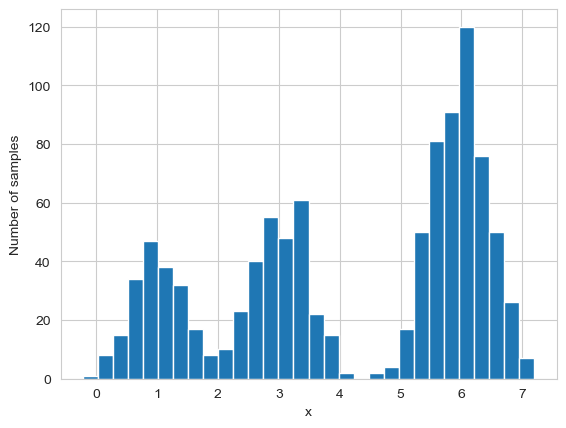

In [48]:
# Histogram of the data
plt.hist(x, bins=30)
plt.xlabel('x')
plt.ylabel('Number of samples')
plt.show()

### Run CAVI

In [49]:
# Algorithm parameters
np.random.seed(0)
max_iter = 300
tol = 1e-3
K = 3
N = x.shape[0]
step_size = 0.1

# Prior parameters
nu_0 = np.array([1., 1., 1.]) * 2.
lambda_0 = 10.
alpha_0 = 1.
beta_0 = 1.
delta_0 = np.ones(K) * N/K
prior_params = (nu_0, lambda_0, alpha_0, beta_0, delta_0)

# Run CAVI
out = CAVI_algorithm(x, K, prior_params, max_iter, tol, step_size=step_size)


### Plot the ELBO

Text(0.5, 1.0, 'ELBO over iterations')

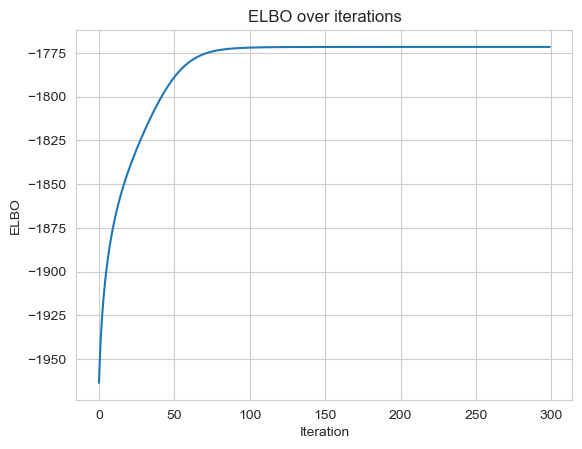

In [50]:
plt.plot(out['ELBO'])
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO over iterations')

### Visualize the model fit
Below we visualize the model fit by plotting the data and the inferred components based on the Expected values of the inferred latent variables and parameters. We are using formulation (1) of the GMM presented in 3.1.1.1.

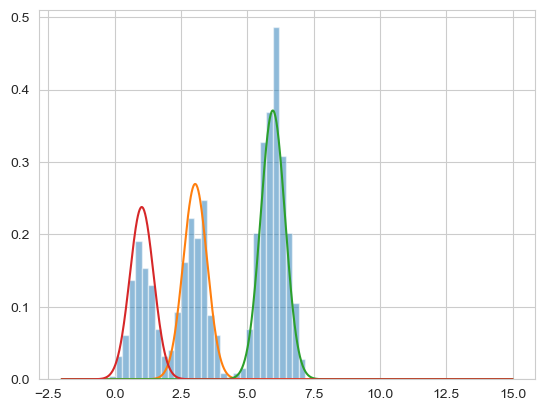

In [51]:
import scipy.stats as sp_stats
x_axis = np.linspace(-2, 15, 1000)
plt.hist(x, bins=30, density=True, alpha=0.5, label='Data')
for k in range(K):
    E_mu_k = out['nu_q'][-1][k]
    E_tau_k = out['alpha_q'][-1][k] / out['beta_q'][-1][k]
    E_pi_k = out['delta_q'][-1][k] / np.sum(out['delta_q'][-1])
    plt.plot(x_axis, E_pi_k * sp_stats.norm.pdf(x_axis, E_mu_k, 1 / np.sqrt(E_tau_k)),
             label=f'Component {k + 1}')

### Plot parameters trajectories

Plot the trajectories of the variational parameters over the iterations. Think of how this relates to the visualization of the VI optimization used in the video lectures and at the Workshop.

Text(0.5, 1.0, 'alpha_q and beta_q trajectories')

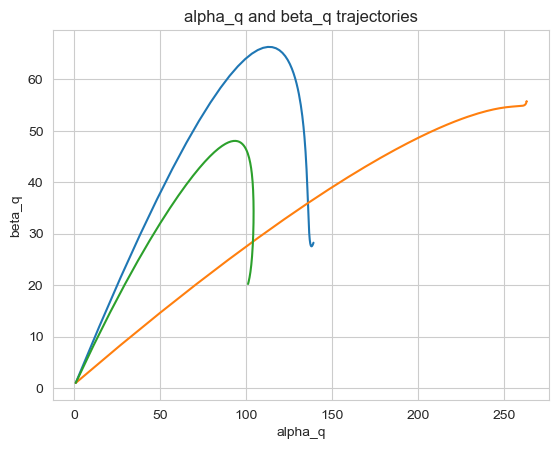

In [52]:
plt.plot(out['alpha_q'], out['beta_q'])
plt.xlabel('alpha_q')
plt.ylabel('beta_q')
plt.title('alpha_q and beta_q trajectories')

### Label switching

The labels of the clusters inferred by the algorithm can be permuted compared to the true labels. This is known as the label switching problem. One way to handle this is to find the permutation of the inferred labels that best matches the true labels.

In [53]:
print(f"True pi: {pi_true}")
print(f"E_q[pi]: {out['delta_q'][-1]/np.sum(out['delta_q'][-1])}")
print(f"True mu: {mu_true}")
print(f"E_q[mu]: {out['nu_q'][-1]}")

True pi: [0.2 0.3 0.5]
E_q[pi]: [0.30473708 0.42851919 0.26674374]
True mu: [1 3 6]
E_q[mu]: [3.03442387 5.96121444 1.0198395 ]
